In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Загрузка данных
data = pd.read_csv('heart_disease_uci.csv')

# Посмотрим первые 5 строк
print(data.head())

# Общая информация по датасету
print(data.info())

# Статистика по числовым колонкам
print(data.describe())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  
<class '

# Step 2. Preprocessing

2.1. Transform the target feature num into binary:

In [3]:
data['target'] = data['num'].apply(lambda x: 1 if x > 0 else 0)
data.drop(columns=['num', 'id'], inplace=True)  # Убираем исходный target и id (он не нужен)


2.2. Let's check the data types and divide the features into numerical and categorical:

In [4]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'target']
Categorical columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


# Step 3. Separation into features and purpose

In [12]:
# Step 3. Separation into features and target
X = data.drop('target', axis=1)
y = data['target']

# Step 4. Identify numerical and categorical columns from X (без 'target')
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


# Step 4. Splitting into training and test samples

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Step 5. Building a preprocessing pipeline

For numerical features — filling gaps with the mean and scaling.

For categorical features — filling gaps with the most frequent value and one-hot coding.

In [14]:
# Импутеры
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Препроцессоры
num_pipeline = Pipeline([
    ('imputer', num_imputer),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', cat_imputer),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])


# Step 6. Creating a complete pipeline with the model

In [15]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [16]:
X = data.drop('target', axis=1)
y = data['target']

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()


# Step 7. Train the model

In [17]:
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalch', 'oldpeak', 'ca']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'dataset', 'cp',
                                                   'fbs', 'restecg', 'exang',
                                                   'slope', 'thal'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

# Step 8. Model evaluation

Accuracy: 0.8478260869565217
Precision: 0.8363636363636363
Recall: 0.9019607843137255
F1 Score: 0.8679245283018868

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        82
           1       0.84      0.90      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



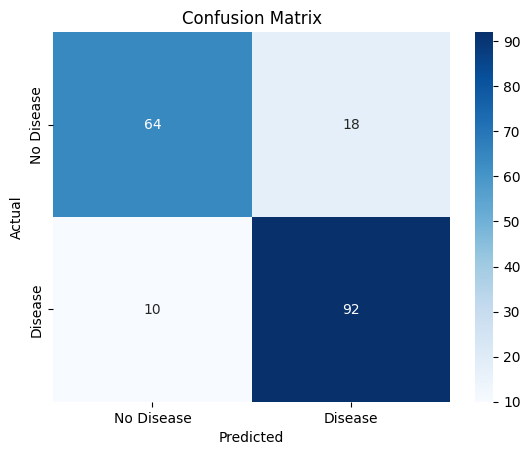

In [18]:
y_pred = model_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Summary
A logistic regression model was built to perform binary prediction of heart disease using the Heart Disease UCI dataset.

Preprocessing included handling missing values, encoding categorical features, and scaling numerical ones.

The model achieved on the test set:

Accuracy: 84.8%

Precision: 83.6%

Recall: 90.2%

F1 Score: 86.8%

These results demonstrate the model’s strong effectiveness in identifying patients with heart disease.